<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>

# Lab: K-Nearest Neighbors Classifier

Estimated time needed: **25** minutes

## Objectives

After completing this lab you will be able to:

*   Use K-Nearest neighbors to classify data
*   Apply KNN classifier on a real world data set 


In this lab you will load a customer data set, fit the data, and use K-Nearest Neighbors to predict a data point.


## Import the libraries

First, to make sure that all required libraries are available, run the cell below.


In [ ]:
!pip install numpy==2.2.0
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3
!pip install seaborn==0.13.2

Now, let's load required libraries.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

<div id="about_dataset">
    <h2>About the data set</h2>
</div>


Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. It is a classification problem. That is, given the dataset,  with predefined labels, we need to build a model to be used to predict class of a new or unknown case.

The example focuses on using demographic data, such as region, age, and marital, to predict usage patterns.

The target field, called **custcat**, has four possible service categories that correspond to the four customer groups, as follows:

1. Basic Service
2. E-Service
3. Plus Service
4. Total Service

Our objective is to build a classifier to predict the service category for unknown cases. We will use a specific type of classification called K-nearest neighbors.


### Load Data 


Let's read the data using pandas library and print the first five rows.


In [2]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/teleCust1000t.csv')
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


<div id="visualization_analysis">
    <h2>Data Visualization and Analysis</h2> 
</div>


Let us first look at the class-wise distribution of the data set.


In [3]:
df['custcat'].value_counts()

custcat
3    281
1    266
4    236
2    217
Name: count, dtype: int64

Hence, we can say that we have records of 281 customers who opt for Plus Services, 266 for Basic-services, 236 for Total Services, and 217 for E-Services. It can thus be seen that the data set is mostly balanced between the different classes and requires no special means of accounting for class bias.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


We can also visualize the correlation map of the data set to determine how the different features are related to each other. 


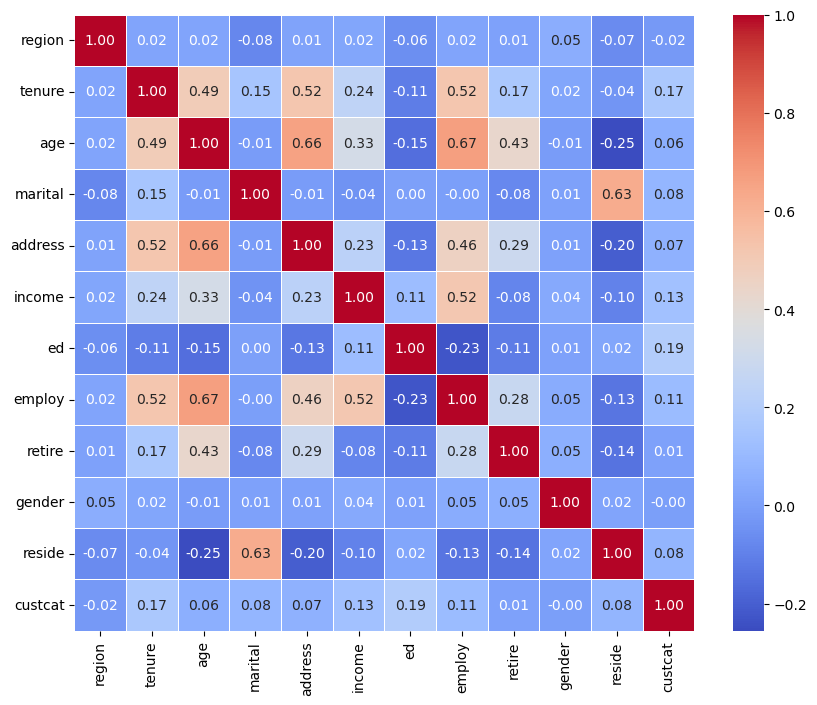

In [7]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

As is visible from the correlation map, some features have beeter correlation among them than others, basically indicating the depth of relationship between the two features. What is of interest to us is the correlation of the target feature, i.e. `custcat` with all the other features. This will help us identify which features should be focussed on for modeling and which ones can be ignored. 

The following code snippet will give us a list of features sorted in the descending order of their absolute correlation values with respect to the target field.


In [8]:
correlation_values = abs(df.corr()['custcat'].drop('custcat')).sort_values(ascending=False)
correlation_values

ed         0.193864
tenure     0.166691
income     0.134525
employ     0.110011
marital    0.083836
reside     0.082022
address    0.067913
age        0.056909
region     0.023771
retire     0.008908
gender     0.004966
Name: custcat, dtype: float64

This shows us that the features `retire` and `gender` have the least effect on `custcat` while `ed` and `tenure` have the most effect.


### Separate the input and target features


Now, we can separate the data into the input data set and the target data set.


In [9]:
X = df.drop('custcat',axis=1)
y = df['custcat']

## Normalize Data


Data normalization is important for the KNN model. 

KNN makes predictions based on the distance between data points (samples), i.e. for a given test point, the algorithm finds the k-nearest neighbors by measuring the distance between the test point and other data points in the dataset. By normalizing / standardizing the data, you ensure that all features contribute equally to the distance calculation. Since normalization scales each feature to have zero mean and unit variance, it puts all features on the same scale (with no feature dominating due to its larger range).

This helps KNN make better decisions based on the actual relationships between features, not just on the magnitude of their values.


In [10]:
X_norm = StandardScaler().fit_transform(X)

### Train Test Split

Now, you should separate the training and the testing data. You can retain 20% of the data for testing purposes and use the rest for training. Assigning a random state ensures reproducibility of the results across multiple executions.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=4)

## KNN Classification


Once the data is in place, we can now execute the training of the model.


### Training
Initially, you may start by using a small value as the value of k, say k = 4.


In [12]:
k = 3
#Train Model and Predict  
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_model = knn_classifier.fit(X_train,y_train)

### Predicting
Once the model is trained, we can now use this model to generate predictions for the test set. 


In [13]:
yhat = knn_model.predict(X_test)

### Accuracy evaluation

In multilabel classification, **accuracy classification score** is a function that computes subset accuracy. This function is equal to the jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.


In [14]:
print("Test set Accuracy: ", accuracy_score(y_test, yhat))

Test set Accuracy:  0.315


### Exercise 1
Can you build the model again, but this time with k=6?


In [16]:
# write your code here
k = 6
#Train Model and Predict  
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_model = knn_classifier.fit(X_train,y_train)

yhat = knn_model.predict(X_test)

print("Test set Accuracy: ", accuracy_score(y_test, yhat))

Test set Accuracy:  0.31


<details><summary>Click here for the solution</summary>

```python
k = 6
knn_model_6 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat6 = knn_model_6.predict(X_test)
print("Test set Accuracy: ", accuracy_score(y_test, yhat6))

```

</details>


### Choosing the correct value of k

K in KNN, is the number of nearest neighbors to examine. However, the choice of the value of 'k' clearly affects the model. Therefore, the appropriate choice of the value of the variable `k` becomes an important task. The general way of doing this is to train the model on a set of different values of k and noting the performance of the trained model on the testing set. The model with the best value of `accuracy_score` is the one with the ideal value of the parameter k.

Check the performance of the model for 10 values of k, ranging from 1-9. You can evaluate the accuracy along with the standard deviation of the accuracy as well to get a holistic picture of the model performance.


In [17]:
Ks = 10
acc = np.zeros((Ks))
std_acc = np.zeros((Ks))
for n in range(1,Ks+1):
    #Train Model and Predict  
    knn_model_n = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = knn_model_n.predict(X_test)
    acc[n-1] = accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

### Plot the model accuracy for a different number of neighbors.
Now, you can plot the model accuracy and the standard deviation to identify the model with the most suited value of k.


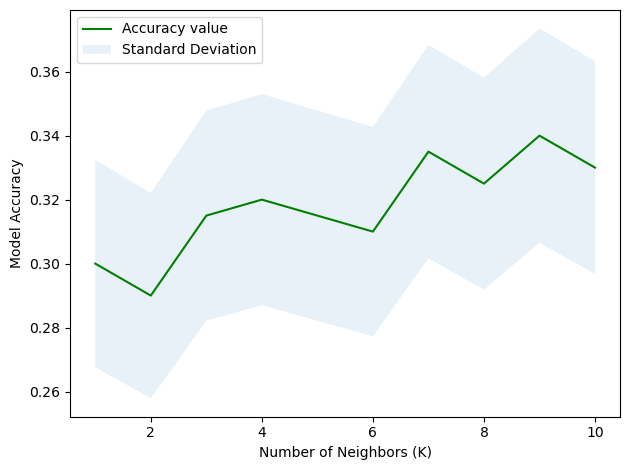

In [18]:
plt.plot(range(1,Ks+1),acc,'g')
plt.fill_between(range(1,Ks+1),acc - 1 * std_acc,acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy value', 'Standard Deviation'))
plt.ylabel('Model Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [19]:
print( "The best accuracy was with", acc.max(), "with k =", acc.argmax()+1) 

The best accuracy was with 0.34 with k = 9


However, since this graph is still rising, there can be a chance that the model will give a better performance with an even higher value of k.

### Exercise 2
Run the training model for 30 values of k and then again for 100 values of k. Identify the value of k that best suits this data and the accuracy on the test set for this model.


Enter you answer here


In [20]:
Ks = 30
acc = np.zeros((Ks))
std_acc = np.zeros((Ks))
for n in range(1,Ks+1):
    #Train Model and Predict  
    knn_model_n = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = knn_model_n.predict(X_test)
    acc[n-1] = accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

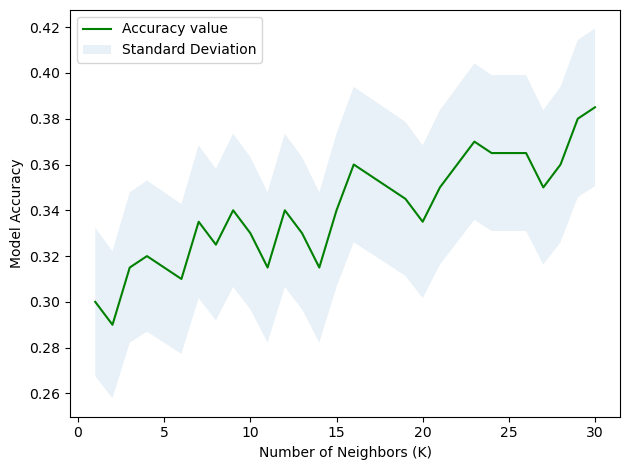

In [21]:
plt.plot(range(1,Ks+1),acc,'g')
plt.fill_between(range(1,Ks+1),acc - 1 * std_acc,acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy value', 'Standard Deviation'))
plt.ylabel('Model Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [22]:
Ks = 100
acc = np.zeros((Ks))
std_acc = np.zeros((Ks))
for n in range(1,Ks+1):
    #Train Model and Predict  
    knn_model_n = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = knn_model_n.predict(X_test)
    acc[n-1] = accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

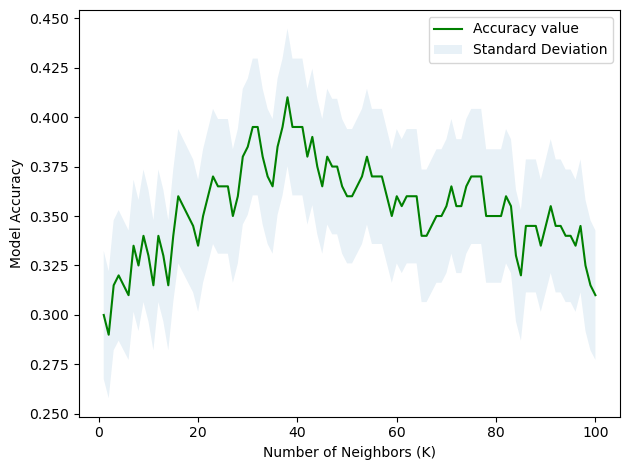

In [23]:
plt.plot(range(1,Ks+1),acc,'g')
plt.fill_between(range(1,Ks+1),acc - 1 * std_acc,acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy value', 'Standard Deviation'))
plt.ylabel('Model Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

<details><summary>Click here for answer</summary>
Execute the cells above by changing the value of the variable `Ks` to 30 and then try again by changing it to 100. In case of 30 values, you should find that the best value of accuracy is achieved for k=30, which again indicates that there is a further scope of improvement. In case of 100 values, you will find that the best value of accuracy is achieved for k=38, after which the model performance starts declining. Hence, the best choice of the value for k is 38, yielding 41% accuracy score.
</details>


### Exercise 3
Plot the variation of the accuracy score for the **training set** for 100 value of Ks.


In [ ]:
# your code here


<details><summary>Click here for the solution</summary>

```python
Ks =100
acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    knn_model_n = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = knn_model_n.predict(X_train)
    acc[n-1] = accuracy_score(y_train, yhat)
    std_acc[n-1] = np.std(yhat==y_train)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),acc,'g')
plt.fill_between(range(1,Ks),acc - 1 * std_acc, acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy value', 'Standard Deviation'))
plt.ylabel('Model Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
```
</details>


### Exercise 4

Can you justify why the model performance on training data is deteriorating with increase in the value of k?


Enter you answer here


<details><summary>Click here for the solution</summary>

When k is small (e.g., k=1), the model is highly sensitive to the individual points in the dataset. The prediction for each point is based on its closest neighbor, which can lead to highly specific and flexible boundaries. This leads to overfitting on the training data, meaning the model will perform very well on the training set, potentially achieving 100% accuracy. However, it may generalize poorly to unseen data.
When k is large, the model starts to take into account more neighbors when making predictions. This has two main consequences:
1. Smoothing of the Decision Boundary: The decision boundary becomes smoother, which means the model is less sensitive to the noise or fluctuations in the training data. 
2. Less Specific Predictions: With a larger k, the model considers more neighbors and therefore makes more generalized predictions, which can lead to fewer instances being classified perfectly.

As a result, the model starts to become less flexible, and its ability to memorize the training data (which can lead to perfect accuracy with small k) is reduced.
</details>


### Exercise 5
We can see that even the with the optimum values, the KNN model is not performing that well on the given data set. Can you think of the possible reasons for this?


Enter you answer here


<details><summary>Click here for the solution</summary>
The weak performance on the model can be due to multiple reasons.
    1. The KNN model relies entirely on the raw feature space at inference time. If the features do no provide clear boundaries between classes, KNN model cannot compensate through optimization or feature transformation.
    2. For a high number of weakly correlated features, the number of dimensions increases, the distance between points tend to become more uniform, reducing the discriminative power of KNN.
    3. The algorithm treats all features equally when computing distances. Hence, weakly correalted features can introduce noise or irrelevant variations in the feature space making it harder for KNN to find meaningful neighbours.
</details>


### Congratulations! You're ready to move on to your next lesson!

## Author
<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/" target="_blank">Abhishek Gagneja</a>
### Other Contributors
<a href="https://www.linkedin.com/in/jpgrossman/" target="_blank">Jeff Grossman</a>  
 
<h3 align="center"> © IBM Corporation. All rights reserved. <h3/>

 
<!--
## Change Log
 
 
|  Date (YYYY-MM-DD) |  Version       | Changed By     | Change Description                  |
|---|---|---|---|
| 2024-11-29         | 3.1            | Jeff Grossman  | Review and make minor edits         |
| 2024-10-31         | 3.0            | Abhishek Gagneja  | Rewrite                             |
| 2020-11-03         | 2.1            | Lakshmi        | Made changes in URL                 |
| 2020-11-03         | 2.1            | Lakshmi        | Made changes in URL                 |
| 2020-08-27         | 2.0            | Lavanya        | Moved lab to course repo in GitLab  |
|   |   |   |   |
